### BRAIN TUMOUR CLASSIFICATION USING CNN(VGG-16)
SAI SUHAS KUMAR


## Installing dependencies 

In [34]:
!pip install imutils
import numpy as np 
import pandas as pd 
import os
import itertools
from os import listdir
import tensorflow as tf
import cv2, glob
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    
import zipfile
import os
import shutil

## Adding the necessary functions and importing the required packages

### Importing models and functions from keras and tensorflow

In [35]:
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import  RMSprop


Download the preprocessed dataset and use it for training the model. The dataset is preprocessed by data augmentation and the augmented data is split into train, test and validation sets with 80%, 10% and 10% fro train, test and validation sets. Each set has two different class images(with and without tumor). The preprocessing dataset can be accessed via : { https://www.kaggle.com/suhasp58/brain-tumor-preprocessed-dataset }.

## Data Preprocessing : Cropping Images

In [36]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    threshold_val = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_val = cv2.erode(threshold_val, None, iterations=2)
    threshold_val = cv2.dilate(threshold_val, None, iterations=2)

    contour = cv2.findContours(threshold_val.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)
  
    left_val = tuple(c[c[:, :, 0].argmin()][0])
    right_val = tuple(c[c[:, :, 0].argmax()][0])
    top_val = tuple(c[c[:, :, 1].argmin()][0])
    bottom_val = tuple(c[c[:, :, 1].argmax()][0])
    
    cropped_image = image[top_val[1]:bottom_val[1], left_val[0]:right_val[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return cropped_image

## Loading the data into Test Train and Validation sets

In [37]:
def dataset_loading(dir_list, image_size):

    X = []
    y = []
 
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
         
            tumour_image = cv2.imread(directory+'/'+filename)
            tumour_image = crop_brain_contour(tumour_image, plot=False)
            tumour_image = cv2.resize(tumour_image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            tumour_image = tumour_image / 255.
            X.append(tumour_image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [38]:
Train_data_path = '../input/brain-tumour-dataset-split/Processed Dataset/train/'
Train_with_tumour =Train_data_path+'yes'
Train_without_tumour = Train_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X_train, y_train = dataset_loading([Train_with_tumour, Train_without_tumour], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1573
X shape is: (1573, 224, 224, 3)
y shape is: (1573, 1)


In [40]:
Test_data_path = '../input/brain-tumour-dataset-split/Processed Dataset/test/'
Test_with_tumour =Test_data_path+'yes'
Test_without_tumour = Test_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X_test, y_test = dataset_loading([Test_with_tumour, Test_without_tumour], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 198
X shape is: (198, 224, 224, 3)
y shape is: (198, 1)


In [41]:
Val_data_path = '../input/brain-tumour-dataset-split/Processed Dataset/val/'
Val_with_tumour =Val_data_path+'yes'
Val_without_tumour = Val_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X_val, y_val = dataset_loading([Val_with_tumour, Val_without_tumour], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 196
X shape is: (196, 224, 224, 3)
y shape is: (196, 1)


## Displaying the data percentage in training, testing and validation sets

In [42]:
def data_percentage(y):
    
    Total=len(y)
    class_1 = np.sum(y)
    class_0 = Total - class_1
    
    pos_prec = (class_1* 100.0)/ Total
    neg_prec = (class_0* 100.0)/ Total
    
    print(f"Number of examples: {Total}")
    print(f"number of pos examples: {class_1}") 
    print(f"number of neg examples: {class_0}")

In [43]:

print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1573
number of pos examples: 868
number of neg examples: 705
Validation Data:
Number of examples: 196
number of pos examples: 108
number of neg examples: 88
Testing Data:
Number of examples: 198
number of pos examples: 109
number of neg examples: 89


## Importing VGG-16 pre-trained model.

In [44]:
vgg16_weight_path = '../input/brain-tumour-dataset-split/Processed Dataset/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
image_size = (224,224)
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=image_size + (3,)
)

## Building the model.

In [45]:

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False



model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


The model built for this project from VGG-16 pretrained layers is shown below.
## 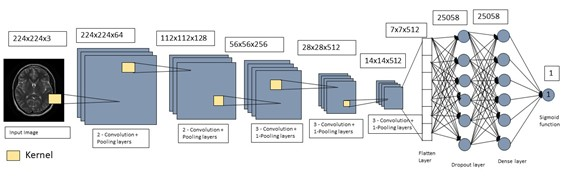

## Running the model and calculating classification results

In [46]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
50/50 [==============================] - 5s 79ms/step - loss: 0.1778 - accuracy: 0.7177 - val_loss: 0.1178 - val_accuracy: 0.8520
Epoch 2/22
50/50 [==============================] - 4s 73ms/step - loss: 0.0936 - accuracy: 0.8754 - val_loss: 0.0683 - val_accuracy: 0.9133
Epoch 3/22
50/50 [==============================] - 4s 76ms/step - loss: 0.0626 - accuracy: 0.9250 - val_loss: 0.0547 - val_accuracy: 0.9337
Epoch 4/22
50/50 [==============================] - 4s 73ms/step - loss: 0.0478 - accuracy: 0.9510 - val_loss: 0.0463 - val_accuracy: 0.9439
Epoch 5/22
50/50 [==============================] - 4s 77ms/step - loss: 0.0470 - accuracy: 0.9453 - val_loss: 0.0447 - val_accuracy: 0.9541
Epoch 6/22
50/50 [==============================] - 4s 73ms/step - loss: 0.0357 - accuracy: 0.9599 - val_loss: 0.0423 - val_accuracy: 0.9541
Epoch 7/22
50/50 [==============================] - 4s 73ms/step - loss: 0.0297 - accuracy: 0.9733 - val_loss: 0.0302 - val_accuracy: 0.9694
Epoch 8/22
50

In [47]:
history = model.history.history

## Plotting Loss vs Accuracy after training the model.

In [48]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    plt.figure()

    # Loss
    

    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
   
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
 
    plt.show()

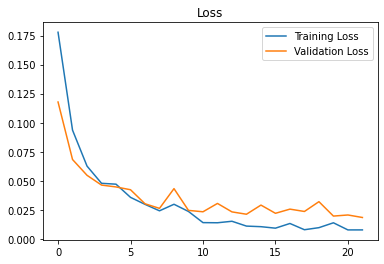

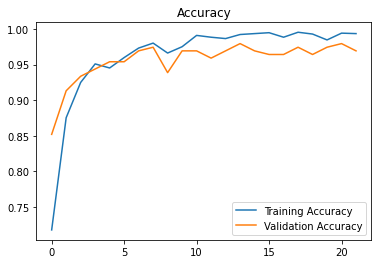

In [49]:
plot_metrics(history)

## Calculating Metrics for the model

### Calcuating metrics on train set.

In [50]:
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_train, predictions) 
print(confusion_mtx)

total=sum(sum(confusion_mtx))

accuracy=(confusion_mtx[0,0]+confusion_mtx[1,1])/total
print ('Accuracy : ', accuracy*100)

sensitivity = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[0,1])
print('Sensitivity : ', sensitivity*100 )

specificity = confusion_mtx[1,1]/(confusion_mtx[1,0]+confusion_mtx[1,1])
print('Specificity : ', specificity*100)

Precision = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[1,0])
print('Precision : ', Precision*100)

f1_score = (2*sensitivity*Precision)/(Precision+sensitivity)
print('F1_score : ',f1_score*100)

[[705   0]
 [  0 868]]
Accuracy :  100.0
Sensitivity :  100.0
Specificity :  100.0
Precision :  100.0
F1_score :  100.0


### Calculating confusion matrix for train dataset

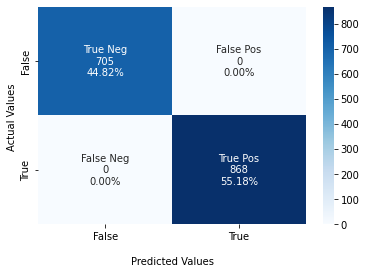

In [51]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtx.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtx.flatten()/np.sum(confusion_mtx)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion_mtx, annot=labels, fmt='', cmap='Blues')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### Calcuating metrics on test set.

In [52]:

predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]


confusion_mtx_test = confusion_matrix(y_test, predictions) 
print(confusion_mtx_test)

total=sum(sum(confusion_mtx_test))

accuracy=(confusion_mtx_test[0,0]+confusion_mtx_test[1,1])/total
print ('Accuracy : ', accuracy*100)

sensitivity = confusion_mtx_test[1,1]/(confusion_mtx_test[1,1]+confusion_mtx_test[1,0])
print('Sensitivity : ', sensitivity*100 )

specificity = confusion_mtx_test[0,0]/(confusion_mtx_test[0,0]+confusion_mtx_test[0,1])
print('Specificity : ', specificity*100)

Precision = confusion_mtx_test[1,1]/(confusion_mtx_test[1,1]+confusion_mtx_test[0,1])
print('Precision : ', Precision*100)

f1_score = (2*sensitivity*Precision)/(Precision+sensitivity)
print('F1_score : ',f1_score*100)


[[ 86   3]
 [  2 107]]
Accuracy :  97.47474747474747
Sensitivity :  98.1651376146789
Specificity :  96.62921348314607
Precision :  97.27272727272728
F1_score :  97.71689497716895


### Calculating confusion matrix for test dataset

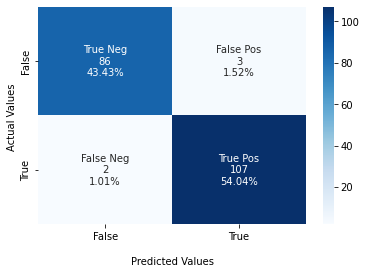

In [53]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtx_test.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtx_test.flatten()/np.sum(confusion_mtx_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion_mtx_test, annot=labels, fmt='', cmap='Blues')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### Calcuating metrics on validation set.

In [54]:
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]


confusion_mtx_val = confusion_matrix(y_val, predictions) 
print(confusion_mtx_val)

total=sum(sum(confusion_mtx_val))

accuracy=(confusion_mtx_val[0,0]+confusion_mtx_val[1,1])/total
print ('Accuracy : ', accuracy*100)

sensitivity = confusion_mtx_val[1,1]/(confusion_mtx_val[1,1]+confusion_mtx_val[1,0])
print('Sensitivity : ', sensitivity*100 )

specificity = confusion_mtx_val[0,0]/(confusion_mtx_val[0,0]+confusion_mtx_val[0,1])
print('Specificity : ', specificity*100)

Precision = confusion_mtx_val[1,1]/(confusion_mtx_val[1,1]+confusion_mtx_val[0,1])
print('Precision : ', Precision*100)

f1_score = (2*sensitivity*Precision)/(Precision+sensitivity)
print('F1_score : ',f1_score*100)

[[ 86   2]
 [  4 104]]
Accuracy :  96.93877551020408
Sensitivity :  96.29629629629629
Specificity :  97.72727272727273
Precision :  98.11320754716981
F1_score :  97.19626168224299


### Calculating confusion matrix for validation dataset

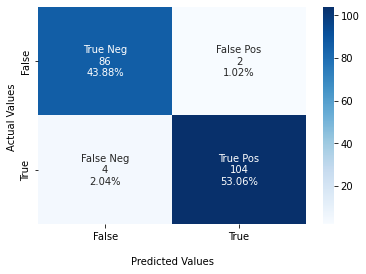

In [55]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mtx_val.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mtx_val.flatten()/np.sum(confusion_mtx_val)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion_mtx_val, annot=labels, fmt='', cmap='Blues')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### Displaying the Actual Dataset before preprocessing

Total Number of images belonging to class 1: 155


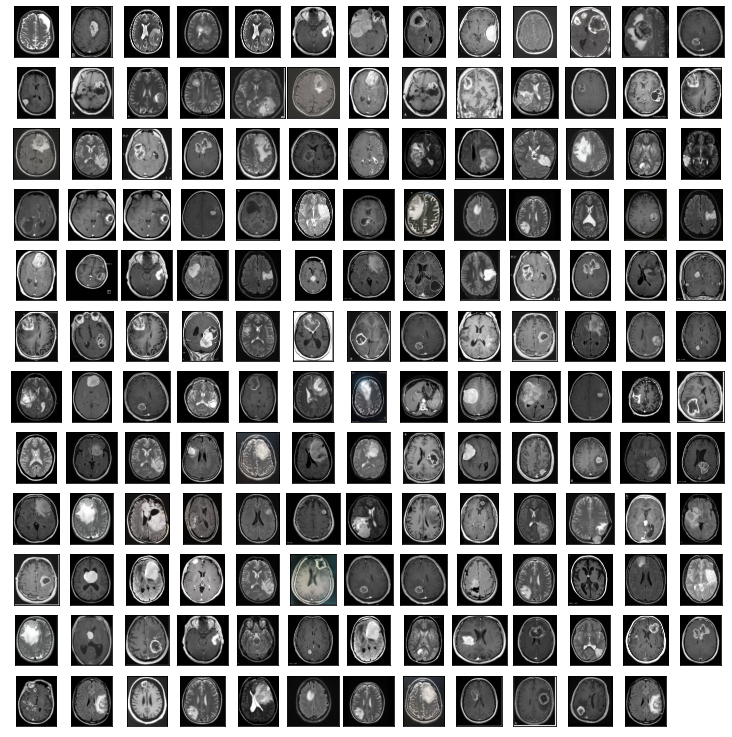

In [56]:
yes = '../input/brain-tumour-dataset-split/Processed Dataset/brain_tumor_dataset/yes/*'

images_yes = [cv2.imread(image) for image in glob.glob(yes)]
y = len(images_yes)
print("Total Number of images belonging to class 1:", y)
fig = plt.figure(figsize=(20,20))  
fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.2, wspace=0)

for i in range(y):
    yes_images = fig.add_subplot(12, 13, i + 1, xticks=[], yticks=[])
    yes_images.imshow(images_yes[i])

Total Number of images belonging to class 0: 98


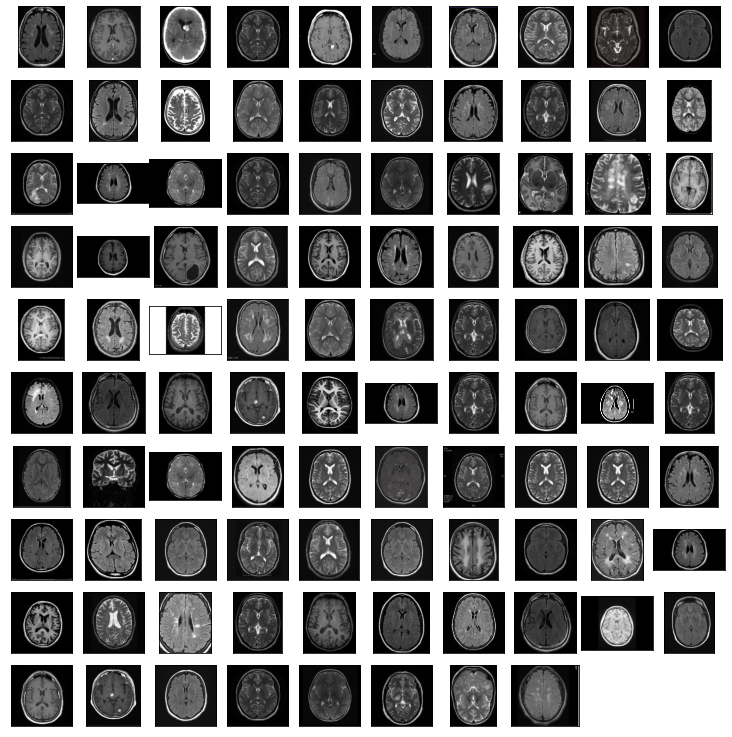

In [57]:
no = '../input/brain-tumour-dataset-split/Processed Dataset/brain_tumor_dataset/no/*'
images_no = [cv2.imread(image) for image in glob.glob(no)]
n = len(images_no)
print("Total Number of images belonging to class 0:", n)

fig = plt.figure(figsize=(20,20))  
fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.2, wspace=0)
for i in range(n):
    no_images = fig.add_subplot(10,10,  i + 1, xticks=[], yticks=[])
    no_images.imshow(images_no[i])

### Displaying True positives, True negatives and misclassified images from the test set

The number of true positives are TP :  107


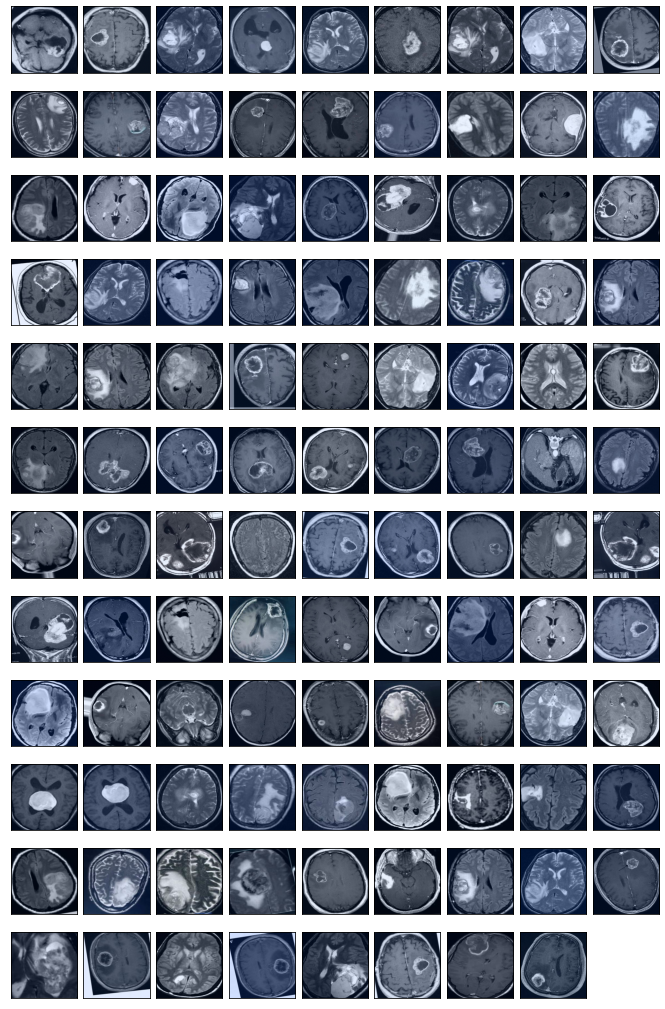

In [58]:
predictions1 = model.predict(X_test)
predictions1 = [1 if x>0.5 else 0 for x in predictions1]
p_array = np.array(predictions1)
y_array = y_test.ravel()
x_list = np.argwhere((y_array!=0) & (p_array!=0))[:, -1]
print("The number of true positives are TP : ", x_list.size)
if x_list.size == 0:
    print('There are no missclassified images.')
else:
    fig = plt.figure(figsize=(30,30))  
    fig.subplots_adjust(left=0, right=0.3, bottom=0, top=0.5, hspace=0.2, wspace=0.1)

    j=0
    for i in x_list:
      ax = fig.add_subplot(13,9,  j + 1, xticks=[], yticks=[])
      ax.imshow(X_test[i])
      j=j+1
      

The number of true negatives are TN :  86


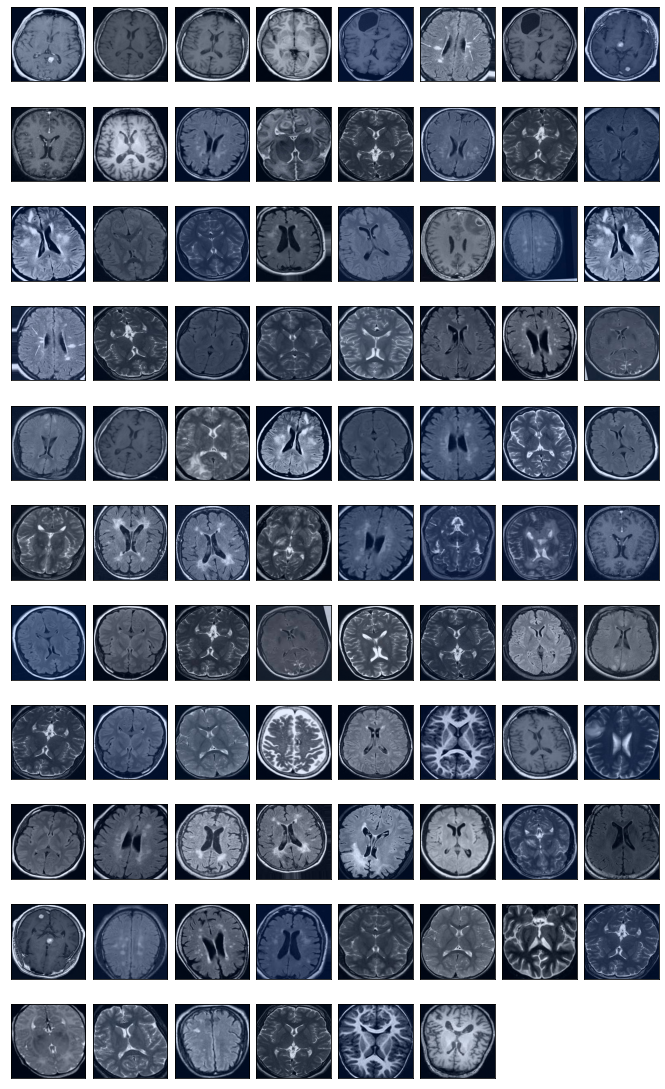

In [59]:
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]
p_array = np.array(predictions)
y_array = y_test.ravel()
x_list = np.argwhere((y_array==0) & (p_array==0))[:, -1]
print("The number of true negatives are TN : ", x_list.size)
if x_list.size == 0:
    print('There are no missclassified images.')
else:
    fig = plt.figure(figsize=(30,30))  
    fig.subplots_adjust(left=0, right=0.3, bottom=0, top=0.5, hspace=0.2, wspace=0.1)
    j=0
    for i in x_list:
      ax = fig.add_subplot(11,8,  j + 1, xticks=[], yticks=[])
      ax.imshow(X_test[i])
      j=j+1
      #plt.title(f'Actual class: {y_array[i]}\nPredicted class: {predictions[i]}')

The number of misclassified images are  :  5


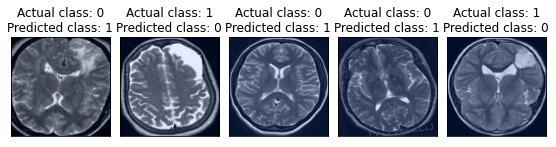

In [60]:
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]
p_array = np.array(predictions)
y_array = y_test.ravel()
x_list = np.argwhere(y_array != p_array)[:, -1]
print("The number of misclassified images are  : ", x_list.size)
if x_list.size == 0:
    print('There are no missclassified images.')
else:
    fig = plt.figure(figsize=(30,30))  
    fig.subplots_adjust(left=0, right=0.5, bottom=0, top=2, hspace=0.2, wspace=0.1)
    j=0
    for i in x_list:
      ax = fig.add_subplot(20,10,  j + 1, xticks=[], yticks=[])
      ax.imshow(X_test[i])
      j=j+1
      plt.title(f'Actual class: {y_array[i]}\nPredicted class: {predictions[i]}')